## I - Work Package 1

#### 0 - Importation of packages and creation of needed functions

In [48]:
#Import the needed packages
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Everything
import numpy as np
import scipy.stats as stats
import pandas as pd
from math import *

def get_data_from_excel(filename,sheetname):
    ### Original data ###
    # Read all the data into a dataframe.
    df_org = pd.read_excel(filename, sheet_name=sheetname, engine='openpyxl')
    return df_org

def get_part_data(filename,sheetname, data=pd.DataFrame()):
    if data.empty:
        # Read all the data
        df_org = get_data_from_excel(filename,sheetname)
    else:
        df_org = data

    # Add a column to record the repair history.
    df_part = df_org.copy()
    df_part.insert(2, 'Repair History', 'Repaired')
    df_part.loc[df_part.loc[:, 'Previous repair po'] == 'MFG', 'Repair History'] = 'Prime'

    # Add a column to record the censoring state.
    df_part.insert(2, 'Censoring', 0)
    df_part.loc[df_part.loc[:,'Repair Status']=='Working', 'Censoring'] = 1

    # Sort by SN
    df_part = df_part.sort_values(by='SN')
    df_part = df_part.reset_index(drop=True)

    # Keep only the necessary columns.
    df_part = df_part.sort_values(by=['SN', 'Censoring'])
    df_part = df_part.reset_index(drop=True)
    df_part = df_part[['SN', 'Censoring', 'Repair History', 'Duration(days)', 'ITEM','Model','Repair Center']]

    return df_part

def components_failure(c,data):
    """C: component name
    data: dataframe for all the reparation"""
    failurelist=[]
    age=0
    censored=[]
    sn=[]
    key=[]
    model=[]
    parts=list(data.SN.unique())
    #grouping data by serial number
    for s in parts:
        #selecting repartion data for one serial number
        selected_part=data[data.SN==s][['Repair PO','Duration(days)', c,'Repair Status','Model']]
        selected_part['Repair PO'] = selected_part['Repair PO'].astype(str)
        selected_part = selected_part.sort_values(['Repair PO']).reset_index(drop=True)

        # Clear the age.
        age = 0
        #the age of one component is the sum for all the duration up to the first replacement of this component
        for i in selected_part.index:
            if selected_part[c][i]==0:
                age+=selected_part['Duration(days)'][i]
            else:
                age+=selected_part['Duration(days)'][i]
                failurelist+=[age]
                sn+=[s]
                key+=[selected_part['Repair PO'][i]]
                model+=[selected_part.Model[i]]
                if selected_part['Repair Status'][i]=='Working' or i==max(selected_part.index):
                    censored+=[1]
                else:
                    censored+=[0]
                age=0
            if selected_part['Repair Status'][i]=='Working' or i==max(selected_part.index):
                failurelist+=[age]
                sn+=[s]
                key+=[selected_part['Repair PO'][i]]
                model+=[selected_part.Model[i]]
                censored+=[1]
    return pd.DataFrame({'SN':sn,'Repair PO':key,'Duration(days)':failurelist,'Model':model, 'Censored': censored})

filename = r'Reliability_data.xlsx'
df_part = get_part_data(filename, 'Reliability_data')

#### 1 - Reliability of the system
To plot the reliability of the system, we choose to separate the censored data (the systems that are still working and have not encountered a failure yet). Those will still be considered by the package, but it will be understood that the items are not failed and still working at the time considered. 

C:\Users\autuo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 6660/6562 (49.62941% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2     Beta 2 Proportion 1       DS      Mu   Sigma      Lambda  Log-likelihood   AICc    BIC      AD optimizer
Weibull_Mixture                         1594.99  1.8177 4616.63    24.8308     0.795926                                             -57945.9 115902 115939 554.216       TNC
     Weibull_DS 1608.61 1.80358                                                         0.800975                                    -57956.6 115919 115942 564.566       TNC
 Loglogistic_2P 1649.25 1.90175                                                                                                     -58116.3 116237 116252 543.098       TNC
 Loglogistic_3P 1649.25 1.90175       0                                                                                             -58116.3 116239 116261 543.098       TNC
     Weibull_CR    

<Figure size 12000x6000 with 0 Axes>

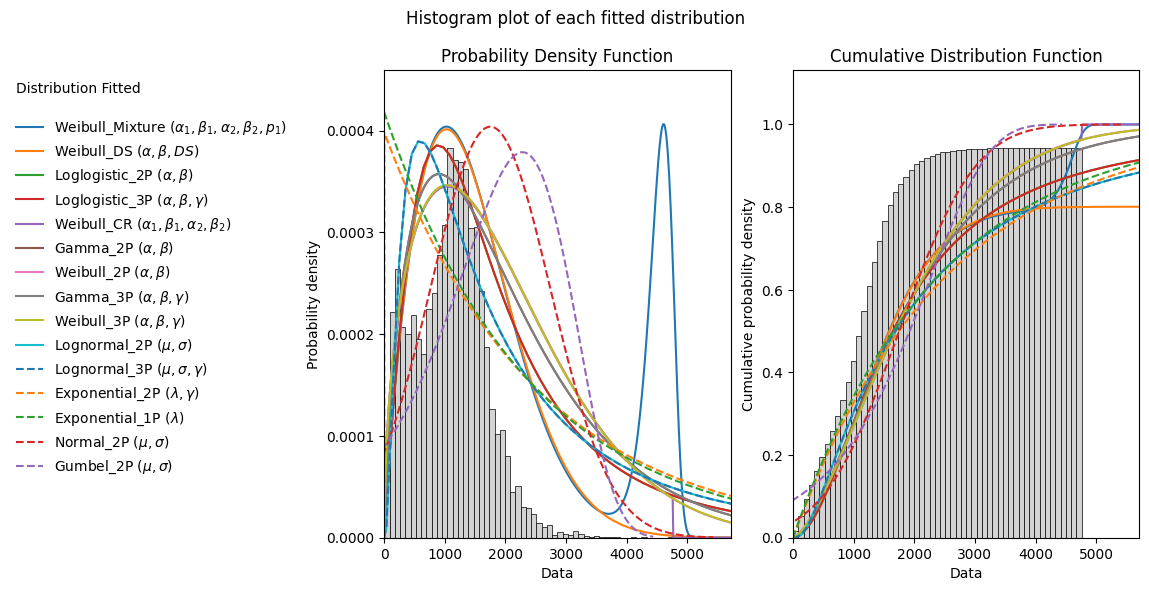

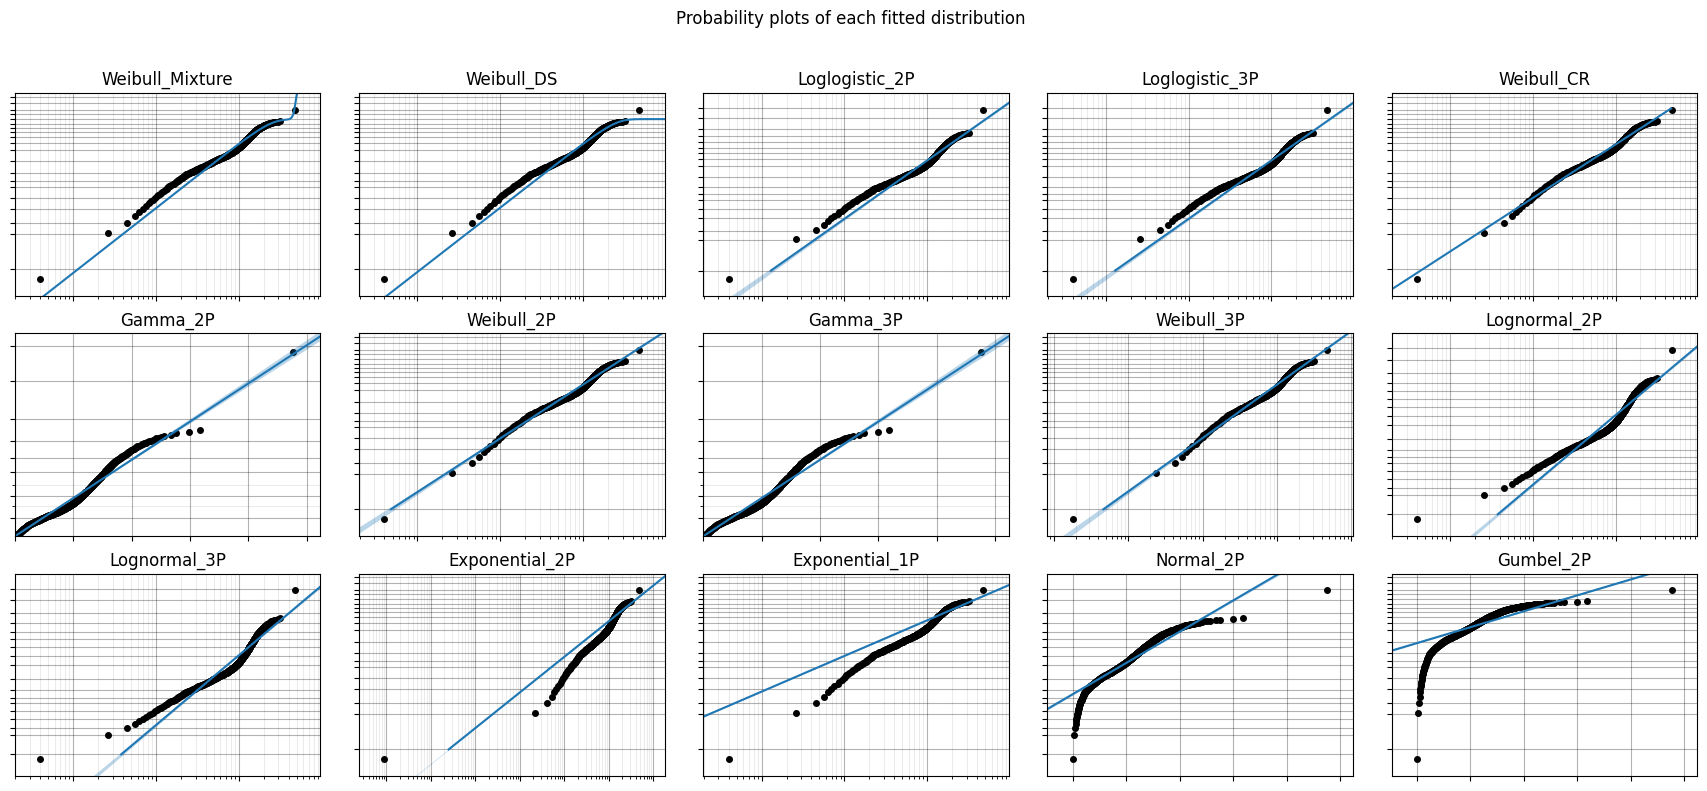

In [49]:
data_uncensored = df_part[df_part['Censoring'] == 0]
data_uncensored = data_uncensored['Duration(days)']
data_list_uncensored = data_uncensored.tolist()

data_censored = df_part[df_part['Censoring'] == 1]
data_censored = data_censored['Duration(days)']
data_list_censored = data_censored.tolist()

fig = plt.figure(figsize=(120, 60))
Fit_Everything(failures=data_list_uncensored, right_censored=data_list_censored, show_histogram_plot=True, show_probability_plot=True, show_PP_plot=False, show_best_distribution_probability_plot=False)

Thanks to the *fit_everything* module of the Reliability Package, we are able to determine that the system most likely has a lifetime probability density following a Loglogistic model with parameters $\alpha$=1649.25 and $\beta$= 1.90175. We choose not to consider the Weibull_Mixture and Weibull_DS distributions because they tend to overfit. Indeed, they consider the case where the data is composed of subpopulations, which is not true in our data. 

#### 2 - Reliability of the components
We will now try to estimate the individual reliabilities of each component. The function provided in part 0 gives us the reliability of a component. 
We will not write the code for every component to lighten the code, and as it is the same base. The laws obtained and the parameters will be resumed in the code in part 3.

C:\Users\autuo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 3912/7529 (65.80718% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1      DS      Mu    Sigma      Lambda  Log-likelihood    AICc     BIC      AD optimizer
Weibull_Mixture                          1409.6 5.65724 4288.97 1.71992     0.287921                                             -34953.5   69917 69953.7 1555.07       TNC
     Weibull_DS 1979.42 2.39773                                                      0.67907                                     -35369.1 70744.1 70766.1  1610.6  L-BFGS-B
 Loglogistic_2P 2237.75 2.47091                                                                                                  -35376.8 70757.7 70772.4 1608.26       TNC
 Loglogistic_3P 2237.75 2.47091       0                                                                                          -35376.8 70759.7 70781.7 1608.26       TNC
       Gamma_2P 936.111 

<Figure size 12000x6000 with 0 Axes>

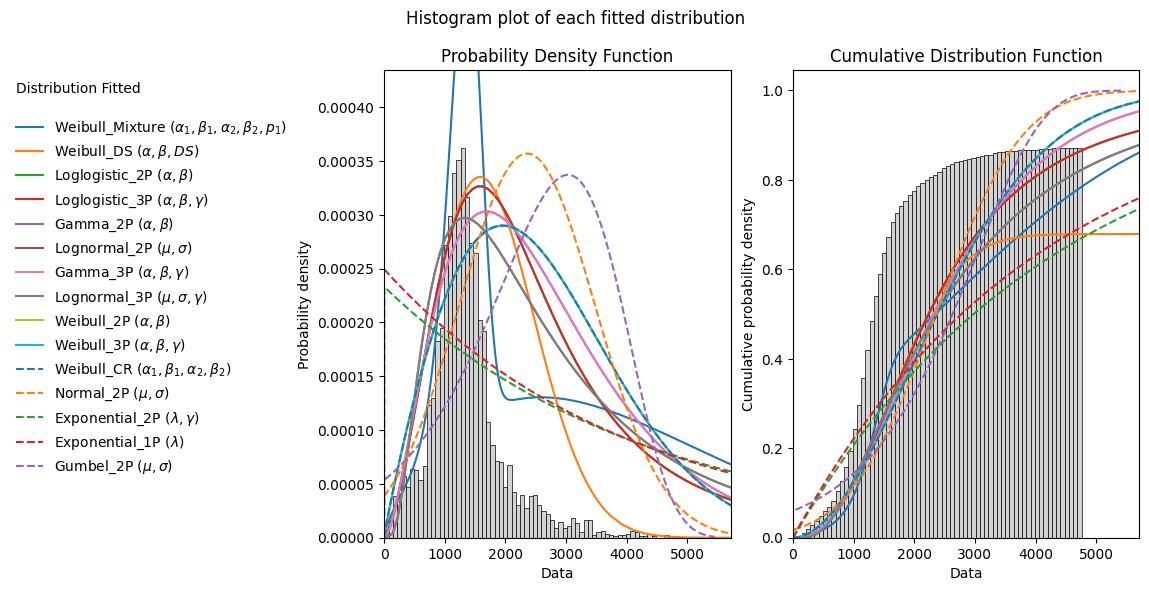

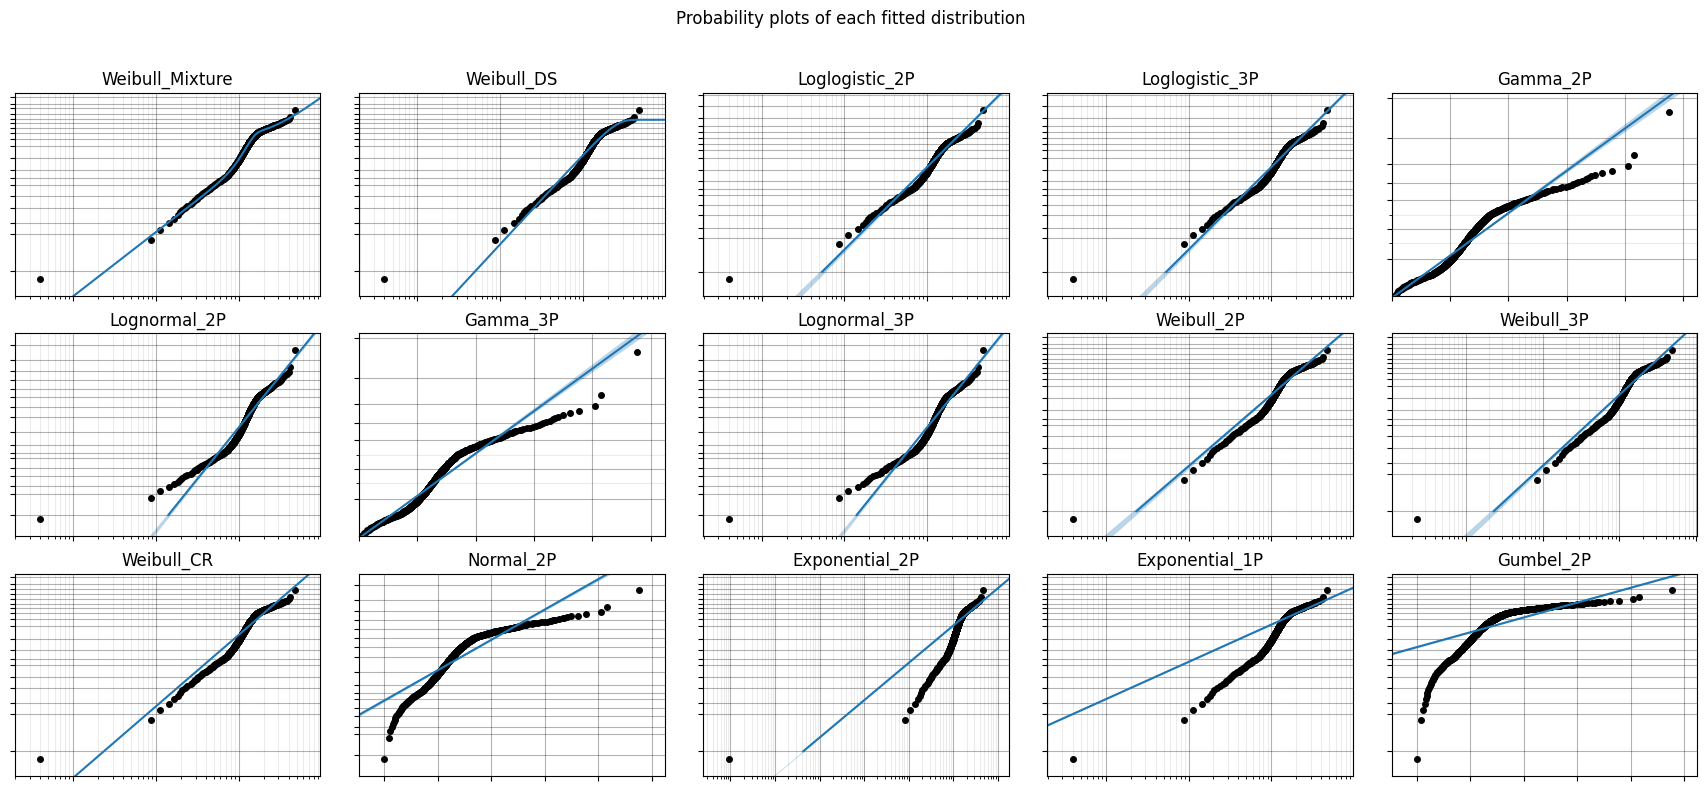

In [50]:
df_component_EDLC= components_failure('EDLC',get_data_from_excel(filename,'Reliability_data'))

data_EDLC = df_component_EDLC[df_component_EDLC['Censored'] == 0]
data_EDLC = data_EDLC['Duration(days)']
data_list_EDLC = data_EDLC.tolist()

data_censored_EDLC = df_component_EDLC[df_component_EDLC['Censored'] == 1]
data_censored_EDLC = data_censored_EDLC['Duration(days)']
data_list_censored_EDLC = data_censored_EDLC.tolist()

fig = plt.figure(figsize=(120, 60))
Fit_Everything(failures=data_list_EDLC, right_censored=data_list_censored_EDLC, show_histogram_plot=True, show_probability_plot=True, show_PP_plot=False, show_best_distribution_probability_plot=False)

#### 3 - Comparison of the system reliability
Considering that the components are in a series system, and that they are independant, the system reliability is given by $R_S(t)=\Pi R_i(t)$ with $R_i(t)$ the reliability of the i-th component. We will compare this equation with the reliability that we found in part 1. We call $R_{Log}(t)$ the reliability given by the Loglogistic model with the parameters found in part 1. 

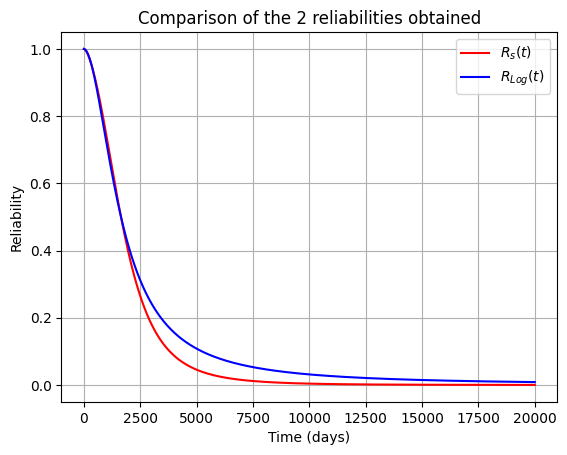

In [51]:
# Define the reliability functions
def reliability_lognormal(t, mu, sigma):
    return 1 - stats.norm.cdf((np.log(t) - mu) / sigma)
def reliability_loglogistic(t, alpha, beta):
    return 1 / (1 + (t / alpha) ** beta)
def reliability_exponential(t, lambd):
    return np.exp(-lambd * t)

# Calculate and trace the produce of the individual reliabilities
def system_reliability(t, parameters):
    reliabilities = [
        reliability_lognormal(t, *parameters[0]), # Composant 1
        reliability_lognormal(t, *parameters[1]), # Composant 2
        reliability_lognormal(t, *parameters[2]), # Composant 3
        reliability_lognormal(t, *parameters[3]), # Composant 4
        reliability_loglogistic(t, *parameters[4]), # Composant 5
        reliability_lognormal(t, *parameters[5]), # Composant 6
        reliability_exponential(t, *parameters[6]), # Composant 7
        reliability_exponential(t, *parameters[7]), # Composant 8
        reliability_exponential(t, *parameters[8]), # Composant 9
        reliability_exponential(t, *parameters[9]), # Composant 10
        reliability_lognormal(t, *parameters[10]) # Composant 11
        ]
    return np.prod(reliabilities)
# Parameters of the distributions of the components
parameters = [
(10.7827, 1.80569), # V700 Mosfet
(10.4597, 1.69239), # Gate Driver
(11.0049, 1.91443), # V700 Busbar
(11.9588, 2.32809), # V700 Filter Board
(2237.75, 2.47091), # EDLC
(9.4441, 1.67407), # V200 Rectifier  Diode
(5.03434e-06,), # V700 Rectifier  Diode
(5.27125e-06,), # IGBT
(3.73133e-06,), # V200 Rectifier  Board
(3.19828e-06,), # V700 Rectifier  Board
(10.6521, 1.8062) # Control Board
]
times = np.linspace(0, 20000, 1000)
system_reliabilities = [system_reliability(t, parameters) for t in times]
plt.plot(times, system_reliabilities, label='$R_s(t)$',color='red')

# Calculate and trace the reliability of the loglogistic distribution
alpha = 1649.25
beta = 1.90175
def survival_function(t, alpha, beta):
    return 1 / (1 + (t / alpha) ** beta)
t = np.linspace(0, 20000, 5000)
reliability = survival_function(t, alpha, beta)
plt.plot(t, reliability, label='$R_{Log}(t)$', color='blue')

plt.xlabel('Time (days)')
plt.ylabel('Reliability')
plt.legend()
plt.grid(True)
plt.title('Comparison of the 2 reliabilities obtained')
plt.show()

Both graphs are pretty similar and follow the same tendancy. The slight difference can be explained by the hypothesis we made saying that the components are independant. We will look at the correlation of the components later in that notebook. 

#### 5 - Conclusion, Potential problems and limitations:
We made several hypotheses, but we don’t know their veracity. For instance, we supposed the system to be in series, but some components could be more important than others. The independence of the components can also be questioned: what if the failure of one component implied the failure of another? Moreover, for the distribution fit of the whole system, we didn’t take the nearest one to the observed failure time because we saw that it was overfitting and the distribution spiked a second time. Therefore, we decided to choose a simpler two-parameter logistic distribution law. 

## II - Work Package 2

#### 1 - Comparison of the components

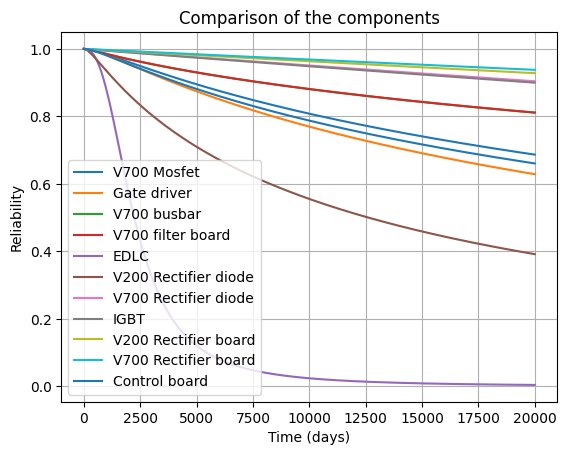

In [52]:
times = np.linspace(0, 20000, 1000)
Composant_1 = [reliability_lognormal(t, *parameters[0]) for t in times]
Composant_2 = [reliability_lognormal(t, *parameters[1]) for t in times]
Composant_3 = [reliability_lognormal(t, *parameters[3]) for t in times]
Composant_4 = [reliability_lognormal(t, *parameters[3]) for t in times]
Composant_5 = [reliability_loglogistic(t, *parameters[4]) for t in times]
Composant_6 = [reliability_lognormal(t, *parameters[5]) for t in times]
Composant_7 = [reliability_exponential(t, *parameters[6]) for t in times]
Composant_8 = [reliability_exponential(t, *parameters[7]) for t in times]
Composant_9 = [reliability_exponential(t, *parameters[8]) for t in times]
Composant_10 = [reliability_exponential(t, *parameters[9]) for t in times]
Composant_11 = [reliability_lognormal(t, *parameters[10]) for t in times]
plt.plot(times, Composant_1, label='V700 Mosfet')
plt.plot(times, Composant_2, label='Gate driver')
plt.plot(times, Composant_3, label='V700 busbar')
plt.plot(times, Composant_4, label='V700 filter board')
plt.plot(times, Composant_5, label='EDLC')
plt.plot(times, Composant_6, label='V200 Rectifier diode')
plt.plot(times, Composant_7, label='V700 Rectifier diode')
plt.plot(times, Composant_8, label='IGBT')
plt.plot(times, Composant_9, label='V200 Rectifier board')
plt.plot(times, Composant_10, label='V700 Rectifier board')
plt.plot(times, Composant_11, label='Control board')
plt.xlabel('Time (days)')
plt.ylabel('Reliability')
plt.title('Comparison of the components')
plt.legend()
plt.grid(True)
plt.show()

The graph points out that the most critical component is EDLC, which fails much faster than any other component.

#### 2 - Correlation

In [53]:
data = get_data_from_excel(filename, 'Reliability_data')
data=data[data['Repair Status'] != 'Working']


# Function to calculate the empirical covariance 
def empirical_covariance(x, y):
   n = min(len(x), len(y))  
   mean_x = np.mean(x[:n])  
   mean_y = np.mean(y[:n])  
   return (np.sum(x[:n] * y[:n]) / n) - (mean_x * mean_y)

components = ['V700 Mosfet', 'Gate driver', 'V700 busbar', 'V700 filter board', 'EDLC',
             'V200 Rectifier diode', 'V700 Rectifier Diode', 'IGBT', 'V200 Rectifier Board',
             'V700 Rectifier board', 'Control board']

l = []
for component in components:
   df_compo = data[component].values
   l.append(df_compo)

n_components = len(components)
cov_matrix = np.zeros((n_components, n_components))


# Calculate the empirical covariance
for i in range(n_components):
   for j in range(i, n_components):
       comp_i_data = l[i]
       comp_j_data = l[j]

       cov_matrix[i, j] = empirical_covariance(comp_i_data, comp_j_data)*100
       cov_matrix[j, i] = cov_matrix[i, j]


# Converting the covariance matrix in a DataFrame
cov_matrix_df = pd.DataFrame(cov_matrix, index=components, columns=components)
print(cov_matrix_df)


                      V700 Mosfet  Gate driver  V700 busbar  V700 filter board  ...       IGBT  V200 Rectifier Board  V700 Rectifier board  Control board
V700 Mosfet               5.08643      2.87342      3.96224           0.363142  ...   0.552341             0.0603937              0.555402       0.136163
Gate driver               2.87342      5.92173      2.86332            0.32664  ...   0.748774              0.200033              0.562463       0.273409
V700 busbar               3.96224      2.86332      4.80402            0.55549  ...   0.586963             0.0188522              0.603099         0.2756
V700 filter board        0.363142      0.32664      0.55549            3.70995  ...  0.0338875             0.0472139              0.147733       0.379217
EDLC                    -0.958431    -0.545661    -0.750676          -0.391804  ...  -0.169555             -0.123624             -0.198658      0.0991803
V200 Rectifier diode    -0.432671    -0.053664    -0.358807          -0.4048

The matrix shows that the first 3 components are highly correlated. This means that if one of these 3 components fails, the other 2 components will most likely fail too. They can be considered as one big component which fails when one of its 3 components fails.
A column will be added in the Excel document to represent that new component $C_*$. It will take the maximum of the value of its three components. If one out the three has failed (its value is 1), $C_*$ failed and its value is 1 too. We now use the Reliability Package to determine the model followed by the component $C_*$.

C:\Users\autuo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 5668/7529 (57.05084% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1       DS      Mu   Sigma      Lambda  Log-likelihood   AICc    BIC      AD optimizer
Weibull_Mixture                         1555.93 1.80363 4642.07 29.2837      0.69827                                             -50318.2 100646 100684 1007.28       TNC
     Weibull_DS 1570.67 1.78902                                                      0.703347                                      -50330 100666 100688 1036.56       TNC
 Loglogistic_2P 1859.73 1.76161                                                                                                    -50452 100908 100923 973.314       TNC
 Loglogistic_3P 1859.73 1.76161       0                                                                                            -50452 100910 100932 973.314       TNC
       Gamma_2P 1394.68 1.67007   

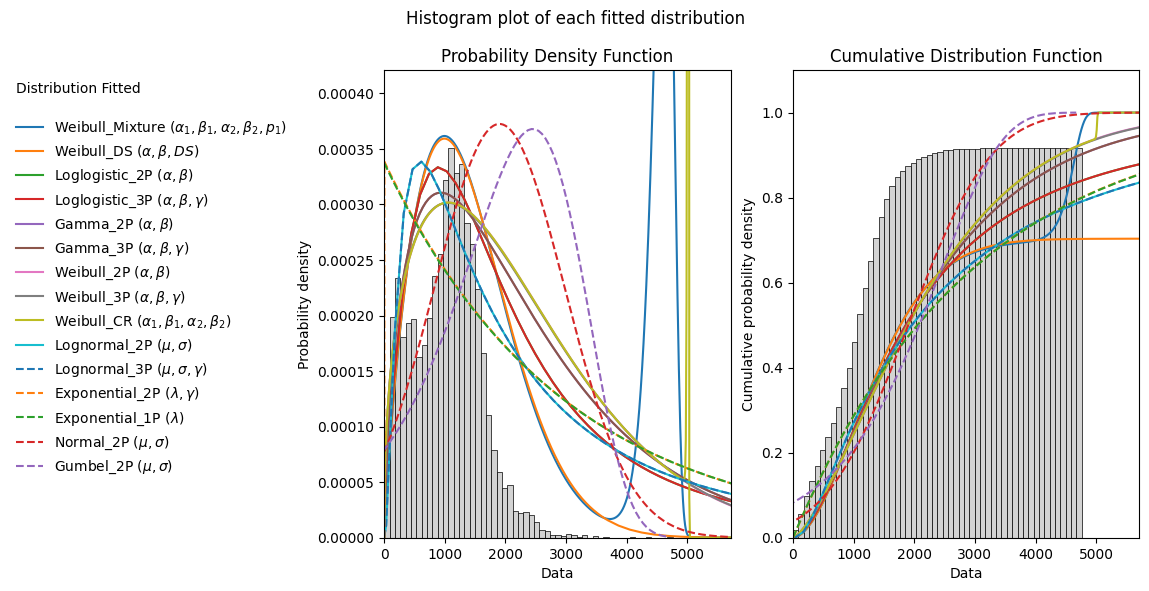

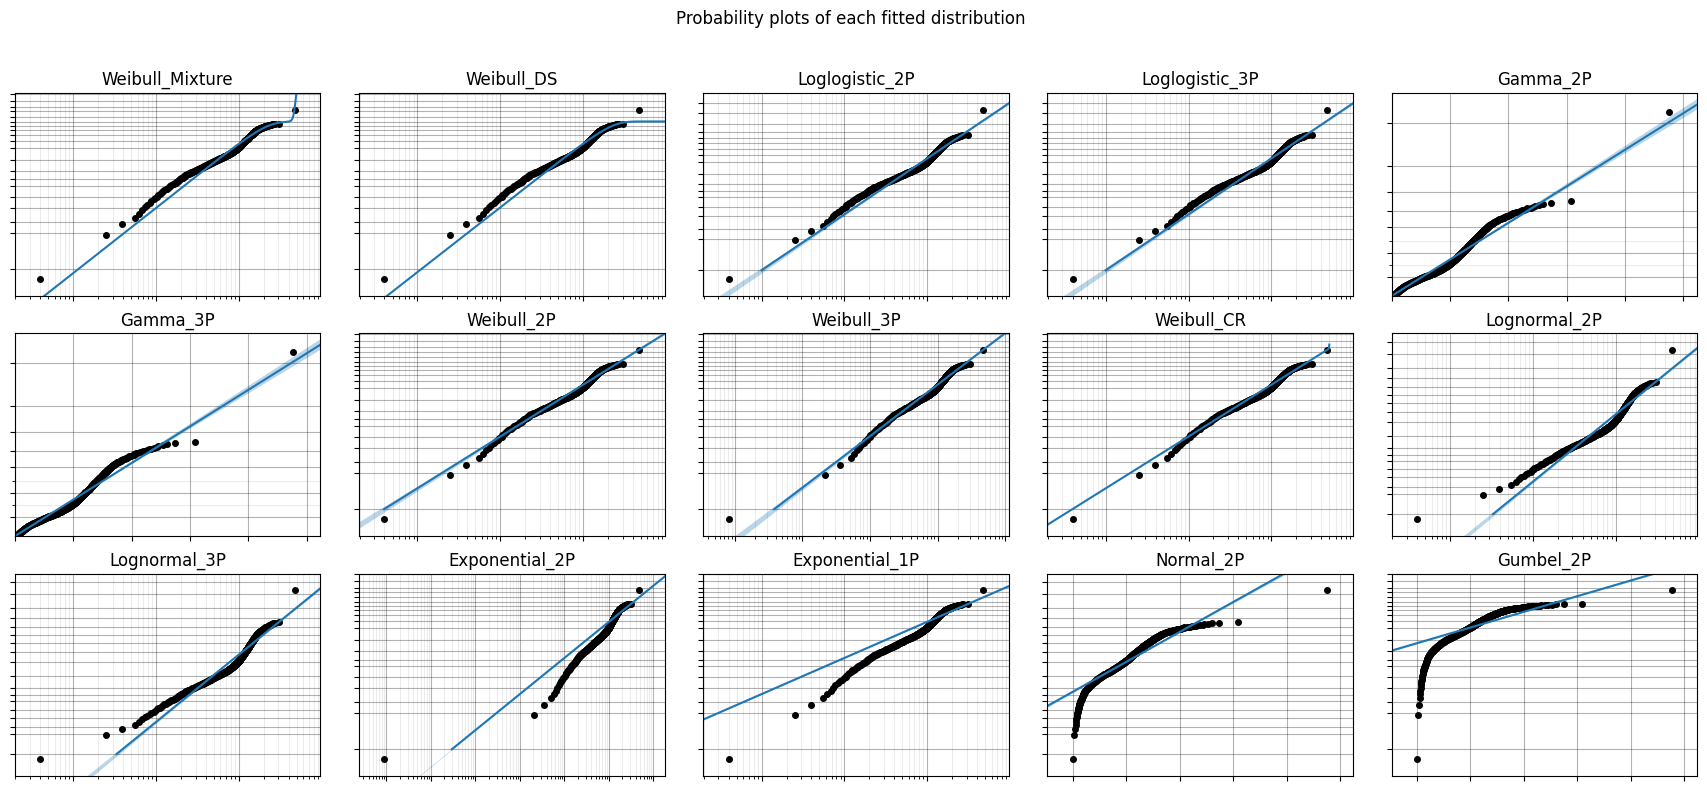

In [54]:
filename = r'Reliability_data_star.xlsx'
sheetname = 'Reliability_data'

df_component_star= components_failure('le max',get_data_from_excel(filename,'Reliability_data'))

data = df_component_star[df_component_star['Censored'] == 0]
data = data['Duration(days)']
data_list = data.tolist()

data_censored = df_component_star[df_component_star['Censored'] == 1]
data_censored = data_censored['Duration(days)']
data_list_censored = data_censored.tolist()

Fit_Everything(failures=data_list, right_censored=data_list_censored, show_histogram_plot=True, show_probability_plot=True, show_PP_plot=False, show_best_distribution_probability_plot=False)


Components 4 to 11 are independant and can now also be considered uncorrelated with $C_*$. Using the independancy property, we get 
$$ P(X_S \geq 2 \ years \ | \ C_1>a_1,...,C_{11}>a_{11}) \\ = \frac{P(X_S \geq 2 \ years\ \cap \ C_1>a_1,...,C_{11}>a_{11})}{P(C_1>a_1,...,C_{11}>a_{11})} \\ = \frac{P(C_1>a_1+2 \ years,...,C_{11}>a_{11}+2 \ years)}{P(C_1>a_1,...,C_{11}>a_{11})} \\ = \frac{P(C_*>a_*+2 \ years){\displaystyle \prod_{i=4}^{11} P(C_i>a_i+2 \ years)}}{P(C_*>a_*){\displaystyle \prod_{i=4}^{11} P(C_i>a_i)}} $$ 
with $$a_* = max (a_1,a_2,a_3)$$

## III - Work Package 3

#### 1 - Determination of the number of systems still working after 2 years
Using the formula for the conditional reliability above, we will determine how many systems would still be working after 2 years, considering that we do not repair them in that time span when they fail, and that all the systems are installed at the same time and follow the same model.

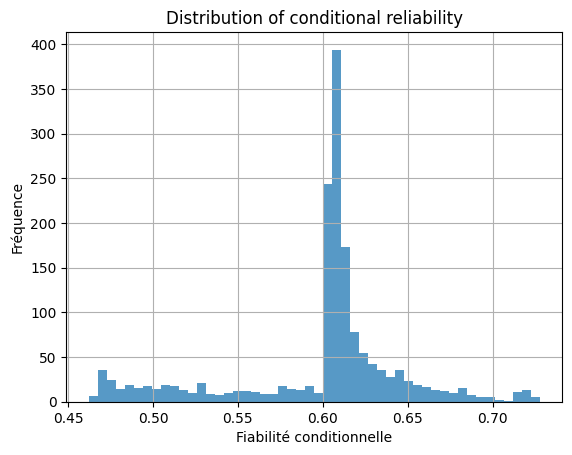

The number of systems still working after 2 years is 969.410544068183


In [55]:
def conditional_system_reliability(t, ages, parameters):
    reliabilities = [
    reliability_loglogistic(t + ages[0], *parameters[0]) / reliability_loglogistic(ages[0], *parameters[0]), # Composant "3 corrélés"
    reliability_lognormal(t + ages[1], *parameters[1]) / reliability_lognormal(ages[1], *parameters[1]), # Composant 4
    reliability_loglogistic(t + ages[2], *parameters[2]) / reliability_loglogistic(ages[2], *parameters[2]), # Composant 5
    reliability_lognormal(t + ages[3], *parameters[3]) / reliability_lognormal(ages[3], *parameters[3]), # Composant 6
    reliability_exponential(t + ages[4], *parameters[4]) / reliability_exponential(ages[4], *parameters[4]), # Composant 7
    reliability_exponential(t + ages[5], *parameters[5]) / reliability_exponential(ages[5], *parameters[5]), # Composant 8
    reliability_exponential(t + ages[6], *parameters[6]) / reliability_exponential(ages[6], *parameters[6]), # Composant 9
    reliability_exponential(t + ages[7], *parameters[7]) / reliability_exponential(ages[7], *parameters[7]), # Composant 10
    reliability_lognormal(t + ages[8], *parameters[8]) / reliability_lognormal(ages[8], *parameters[8]) # Composant 11
    ]
    return np.prod(reliabilities)

parameters = [
(1859.73, 1.76161), # C_*   1859.73 1.76161  
(11.9588, 2.32809), # Composant 4
(2237.75, 2.47091), # Composant 5
(9.4441, 1.67407), # Composant 6
(5.03434e-06,), # Composant 7
(5.27125e-06,), # Composant 8
(3.73133e-06,), # Composant 9
(3.19828e-06,), # Composant 10
(10.6521, 1.8062) # Composant 11
]

filename = r'ST4 Project final data.xlsx'
sheetname = 'Spare parts demand corélés' 
df = pd.read_excel(filename, sheet_name=sheetname)

age_columns = ['3 corrélés', 'V700 filter board', 'EDLC', 'V200 Rectifier diode', 'V700 Rectifier Diode', 'IGBT', 'V200 Rectifier Board', 'V700 Rectifier board', 'Control board']
ages_data = df[age_columns].values
t_future = 730 # Wanted duration : 2 years
conditional_reliabilities = [conditional_system_reliability(t_future, ages, parameters) for ages in ages_data]
df['Fiabilité conditionnelle'] = conditional_reliabilities

# Plot the distribution of conditional reliabilities
plt.hist(conditional_reliabilities, bins=50, alpha=0.75)
plt.xlabel('Fiabilité conditionnelle')
plt.ylabel('Fréquence')
plt.title('Distribution of conditional reliability')
plt.grid(True)
plt.show()

# Calculate the mean number of systems still working after 2 years
nombre_moyen_systemes_en_vie = sum(conditional_reliabilities)
print(f"The number of systems still working after 2 years is {nombre_moyen_systemes_en_vie}")


After 2 years, around 969 systems would be working over the 1621 studied ones. 
We can consider that the number of system that are working at a time $t$ can be written $N(t)={\displaystyle \sum_{i=1}^{n} X_i(t|a_i)}$ where $n$ is the number of systems, and $X_i(t|a_i)$ represents the state of the system. $X_i(t|a_i)$ equals $1$ if the i-th spare part is not in the state "failed" at time t, knowing that it was working at time $a_i$, and 0 otherwise, that is $X_i(t)\sim Ber(p_i(t))$ with $p_i(t)=R_i(t)$.
$\\$ We realized that what we did previously was calculate the expectancy of N : $E[N(t)]={\displaystyle \sum_{i=1}^{n} E[X_i(t|a_i)]}={\displaystyle \sum_{i=1}^{n} p_i(t|a_i)}={\displaystyle \sum_{i=1}^{n} R_i(t|a_i)}$ which is exactly what we calculated above. This calculation is not very relevant, considering that it is only a mean value of a random variable. We want to be more precise and try to find the distribution of N(t), as a sum of Bernoulli random variables, and determine the value $n_0$ for which $P(N(t)\geq n_0)=0.99$. That treshold of 0.99 is determined so we are $99$% sure that the number of systems not failed at time $t$ is superior to $n_0$, meaning that the number of failed systems at time $t$ is inferior to $1621-n_0$. 
$\\$ To find the distribution of $N(t)$, we simulate the vector $X(t)=[X_1(t),\ ...\ ,X_n(t)]$ 10 000 times with $n=1620$ and $X_i(t)\sim Ber(p_i(t))$. We then sum the components of $X(t)$ and obtain 10 000 values of N(t) that we can plot in a histogram. 

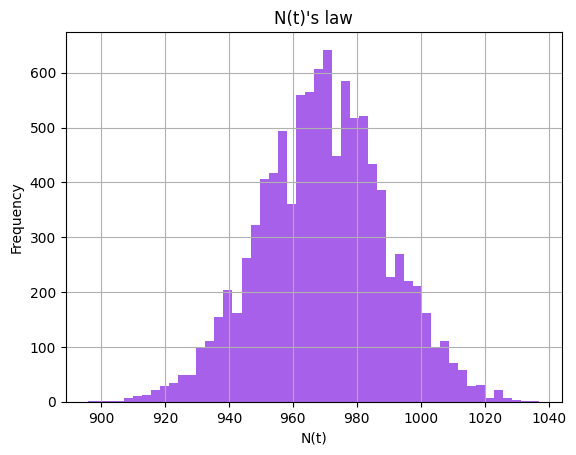

923.0


In [56]:
filename = r'ST4 Project final data.xlsx'
sheetname = 'Spare parts demand corélés' 
df = pd.read_excel(filename, sheet_name=sheetname)

age_columns = ['3 corrélés', 'V700 filter board', 'EDLC', 'V200 Rectifier diode', 'V700 Rectifier Diode', 'IGBT', 'V200 Rectifier Board', 'V700 Rectifier board', 'Control board']
ages_data = df[age_columns].values
t_future = 730 # Wanted duration : 2 years

N=[np.sum([np.random.binomial(1,Ri) for Ri in conditional_reliabilities]) for _ in range(10000)]
    
plt.hist(N, bins=50, alpha=0.75,color = "blueviolet", lw=0)
plt.xlabel('N(t)')
plt.ylabel('Frequency')
plt.title('N(t)\'s law')
plt.grid(True)
plt.show()

print(np.quantile(N,0.01))

$P(N(t)\geq n_0)=0.99 \Leftrightarrow P(N(t) < n_0)=0.01 $ so we calcultate the 1% quantile. We obtain $n_0=923$, which means we will observe no more than 697 failed systems at time $t$ with 99% certainty. 

#### 2 - Prediction of the demand in components
We'll first look at the percentage at which the components fail. The sum of the percentages can be greater than 100%, because two or more components can break at the same time. A component with a percentage of 50% will mean that half of the failures of the system are due to that component. 


In [57]:
components = ['V700 Mosfet', 'Gate driver', 'V700 busbar', 'V700 filter board', 'EDLC',
             'V200 Rectifier diode', 'V700 Rectifier Diode', 'IGBT', 'V200 Rectifier Board',
             'V700 Rectifier board', 'Control board']

data = get_data_from_excel(filename, 'Reliability_data')
data = data[data['Repair Status'] != 'Working']

#Number of failures due to each component
l = []
for component in components:
   l.append(sum(data[component]))

#Percentage of failures due to each component
a = 0
for component in components:
   a += sum(data[component])/len(data)
   print(component, round(sum(data[component])/len(data)*100,2),'%')

V700 Mosfet 5.38 %
Gate driver 6.32 %
V700 busbar 5.06 %
V700 filter board 3.86 %
EDLC 61.13 %
V200 Rectifier diode 18.66 %
V700 Rectifier Diode 1.32 %
IGBT 1.46 %
V200 Rectifier Board 1.11 %
V700 Rectifier board 0.84 %
Control board 6.13 %


From those percentages, we will deduce the components future demand. We want to know how many components we will need to replace in the next 2 years, based on the number of failures of the system, and the percentage of failures due to a particular component. Because we would rather overestimate than underestimate the demand, we will add a 1.1 factor to add 10% of our estimation; and round up the number of components to change to the nearest whole number that is greater.

In [58]:
nombre_total_de_failures = 1620-923
for component in components:
    # Calcul du pourcentage avec incertitude
    demande_future = sum(data[component]) / len(data) * 1.10
    # Calcul du nombre de composants à changer
    nombre_a_changer = demande_future * nombre_total_de_failures
    a += demande_future
    print(f"{component}: future demand : {round(demande_future,3)}, number of components to change : {ceil(nombre_a_changer)}")

V700 Mosfet: future demand : 0.059, number of components to change : 42
Gate driver: future demand : 0.07, number of components to change : 49
V700 busbar: future demand : 0.056, number of components to change : 39
V700 filter board: future demand : 0.042, number of components to change : 30
EDLC: future demand : 0.672, number of components to change : 469
V200 Rectifier diode: future demand : 0.205, number of components to change : 144
V700 Rectifier Diode: future demand : 0.015, number of components to change : 11
IGBT: future demand : 0.016, number of components to change : 12
V200 Rectifier Board: future demand : 0.012, number of components to change : 9
V700 Rectifier board: future demand : 0.009, number of components to change : 7
Control board: future demand : 0.067, number of components to change : 47


## III - Work Package 3
In this part, we will try to estimate the level of safetystock necessary to be able to repair 700 systems per year. 
#### Method 1
This method will be based on a simple formula : $ \\ necessary \ stock \ = \ number \ of \ systems \ to \ repair \ in\ 1 \ year \ * \ proportion \ of \ failures \ due \ to \ the \ component \\$ We will add a margin of 20%, to make sure the company doesn't fail out of stock if following our recommandations. 

In [59]:
nombre_total_de_réparation = 700
stock=[]
for component in components:
    # Calcul du pourcentage avec incertitude
    demande_future = sum(data[component]) / len(data) * 1.20 #ajout d’une marge de 20%
    # Calcul du nombre de composants à changer
    nombre_a_changer = ceil(demande_future * nombre_total_de_réparation)
    stock.append(nombre_a_changer)
    a += demande_future
    print(f"{component}: number of components needed in stock = {nombre_a_changer}")

V700 Mosfet: number of components needed in stock = 46
Gate driver: number of components needed in stock = 54
V700 busbar: number of components needed in stock = 43
V700 filter board: number of components needed in stock = 33
EDLC: number of components needed in stock = 514
V200 Rectifier diode: number of components needed in stock = 157
V700 Rectifier Diode: number of components needed in stock = 12
IGBT: number of components needed in stock = 13
V200 Rectifier Board: number of components needed in stock = 10
V700 Rectifier board: number of components needed in stock = 8
Control board: number of components needed in stock = 52


When a failure of EDLC is indicated by a 1 in the Excel Document, in reality, it means that 2 EDLC components failed, as if 2 EDLC components where put in a parallel structure and both of them failed. The stock indicated above is then incorrect. We will multiply the stock by the number of components failed associated with one failure. 

In [60]:
real_stock=np.array(stock)*np.array([12,1,1,1,2,1,24,2,1,6,1])
for i in range(len(components)):
    print(f"{components[i]}: number of components needed in stock = {real_stock[i]}")

V700 Mosfet: number of components needed in stock = 552
Gate driver: number of components needed in stock = 54
V700 busbar: number of components needed in stock = 43
V700 filter board: number of components needed in stock = 33
EDLC: number of components needed in stock = 1028
V200 Rectifier diode: number of components needed in stock = 157
V700 Rectifier Diode: number of components needed in stock = 288
IGBT: number of components needed in stock = 26
V200 Rectifier Board: number of components needed in stock = 10
V700 Rectifier board: number of components needed in stock = 48
Control board: number of components needed in stock = 52
